In [278]:
%matplotlib inline
import gym
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import deque
from IPython import display
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from scipy import stats
from training_methods import *
%load_ext autoreload
%autoreload

run_name = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [279]:
# env = gym.make('CartPole-v1')
# env.my_preprocess_input = lambda x: x

# env = gym.make('MountainCar-v0')
# env.my_preprocess_input = lambda x: x

# env = gym.make('Breakout-v0')
# env.my_preprocess_input = preprocess_input_breakout_v0

env = gym.make('Pong-v0')  # Reset TD reward by non-null values
env.my_preprocess_input = preprocess_input_pong_v0

# env.render(close=True)
# plt.imshow(env.render('rgb_array'))
print('Actions: {}, Observation space {}, parameters {}, max episode steps {}'.format(
    env.action_space.n, env.observation_space.shape, np.prod(env.observation_space.shape), env.spec.max_episode_steps))

[2017-08-27 10:57:02,723] Making new env: Pong-v0


Actions: 6, Observation space (210, 160, 3), parameters 100800, max episode steps 10000


## Basic Actor-Critic

In [280]:
class ActorCriticAgent:
    def __init__(self, params):
        self.params = params
        self.memory_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_next_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_actions = np.zeros((2 * self.params.max_memory_size))
        self.memory_rewards = np.zeros((2 * self.params.max_memory_size, 1))
        self.cnt = 0
        self._build_actor_model()
        self._build_critic_model()

    def _build_actor_model(self):
        with tf.variable_scope('actor'):
            self.actor_x = tf.placeholder("float", [None, self.params.state_size], name="State")
            self.actor_y = tf.placeholder("float", [None, 1], name="Target")
            self.actor_action = tf.placeholder(tf.int32, [None,], name="Action")

            h0 = tf.contrib.layers.fully_connected(
                inputs=self.actor_x,
                num_outputs=20,
                activation_fn=tf.nn.relu,
                weights_initializer=tf.contrib.layers.xavier_initializer())

            h1 = tf.contrib.layers.fully_connected(
                inputs=h0,
                num_outputs=self.params.action_size,
                activation_fn=None,
                weights_initializer=tf.contrib.layers.xavier_initializer())
            
            self.actor_action_probs = tf.nn.softmax(h1)

            actions_ohe = tf.one_hot(self.actor_action, depth=self.params.action_size)
            self.picked_action_probs = tf.reduce_sum(self.actor_action_probs * actions_ohe, axis=1, keep_dims=True)

            self.actor_cost = tf.reduce_mean(-tf.log(1e-6 + self.picked_action_probs) * self.actor_y)
            self.actor_train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
                .minimize(self.actor_cost)

    def _build_critic_model(self):
        with tf.variable_scope('critic'):
            self.critic_x = tf.placeholder("float", [None, self.params.state_size], name="State")
            self.critic_y = tf.placeholder("float", [None, 1], name="Target")

            h0 = tf.contrib.layers.fully_connected(
                inputs=self.critic_x,
                num_outputs=20,
                activation_fn=tf.nn.relu,
                weights_initializer=tf.contrib.layers.xavier_initializer())

            self.critic_value = tf.contrib.layers.fully_connected(
                inputs=h0,
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.contrib.layers.xavier_initializer())
            
            self.critic_cost = tf.reduce_mean(tf.squared_difference(self.critic_value, self.critic_y))
            self.critic_train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
                .minimize(self.critic_cost)
            
    def remember(self, state, action, reward, next_state, frame):
        self.memory_states[self.cnt] = state
        self.memory_next_states[self.cnt] = next_state
        self.memory_actions[self.cnt] = action
        self.memory_rewards[self.cnt] = reward
        self.cnt += 1
        
        if self.cnt == 2 * self.params.max_memory_size:
            n = self.params.max_memory_size
            self.memory_states[:n] = self.memory_states[-n:]
            self.memory_next_states[:n] = self.memory_next_states[-n:]
            self.memory_actions[:n] = self.memory_actions[-n:]
            self.memory_rewards[:n] = self.memory_rewards[-n:]
            self.cnt = n

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        act_probs = session.run(self.actor_action_probs, {self.actor_x: [state]})[0]
        return np.random.choice(np.arange(len(act_probs)), p=act_probs)

    def think(self, batch_size, episode):
        cnt = self.cnt
        
        values = session.run(self.critic_value, {self.critic_x: self.memory_states[:cnt]})
        nextValues = session.run(self.critic_value, {self.critic_x: self.memory_next_states[:cnt]})
        
        criticY = self.memory_rewards[:cnt] + self.params.gamma * nextValues[:cnt]
        actorY = criticY - values

        P = np.random.permutation(cnt)
        for i in range(0, cnt, batch_size):
            batch_indexes = P[i: i + batch_size]
            states = self.memory_states[batch_indexes]
            actorys = actorY[batch_indexes]
            criticys = criticY[batch_indexes]
            actions = self.memory_actions[batch_indexes]
            
            _ = session.run(self.actor_train_op,
                            {self.actor_x: states, self.actor_y: actorys, self.actor_action: actions})
            _ = session.run(self.critic_train_op,
                            {self.critic_x: states, self.critic_y: criticys})

State shape (304,), actions 6
Run: 2
episode: 2/50, reward -18.0, frames 1000, exploration rate: 1.0
episode: 4/50, reward -17.75, frames 1000, exploration rate: 0.89
episode: 6/50, reward -17.6666666667, frames 1000, exploration rate: 0.79
episode: 8/50, reward -18.25, frames 1000, exploration rate: 0.7
episode: 10/50, reward -17.6, frames 1000, exploration rate: 0.62
episode: 12/50, reward -18.0, frames 1000, exploration rate: 0.55
episode: 14/50, reward -17.4, frames 1000, exploration rate: 0.49
episode: 16/50, reward -17.9, frames 1000, exploration rate: 0.43
episode: 18/50, reward -17.7, frames 1000, exploration rate: 0.38
episode: 20/50, reward -17.3, frames 1000, exploration rate: 0.34
episode: 22/50, reward -16.7, frames 1000, exploration rate: 0.3
episode: 24/50, reward -16.5, frames 1000, exploration rate: 0.27
episode: 26/50, reward -15.6, frames 1000, exploration rate: 0.24
episode: 28/50, reward -15.5, frames 1000, exploration rate: 0.21
episode: 30/50, reward -16.2, frame

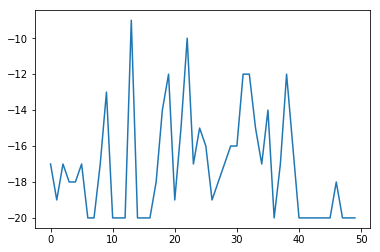

In [282]:
import time
start_time = time.time()

params = LearningParameters(env, episodes_count=50)
params.max_frame_in_episode = min(params.max_frame_in_episode, 1000)
params.epsilon_min = 0.05
params.max_memory_size = 100000

if 'session' in locals():
    session.close()
    tf.reset_default_graph()
    if 'tf_writer' in locals():
        tf_writer.close()
config = tf.ConfigProto(device_count = {'GPU': 0})
session = tf.Session(config=config)
# session = tf.Session()
run_name += 1
print('Run: ' + str(run_name))

agent = ActorCriticAgent(params)

tf_writer = tf.summary.FileWriter('logs/run' + str(run_name), session.graph)

session.run(tf.global_variables_initializer())

agent, rewards = train_discounted_rewards(env, agent, params, normalize_rewards=True)
# agent, rewards = train_reward_is_time(env, agent, params)
# agent, rewards = train(env, agent, params)
plt.plot(rewards)

end_time = time.time()
print('Elapsed: {}, rewards per second {}'.format(end_time - start_time, np.sum(rewards) / (end_time - start_time)))

In [22]:
# Continue learning
params.episodes_count = 500
agent, rewards = train_discounted_rewards(env, agent, params, normalize_rewards=True)
plt.plot(rewards)

KeyboardInterrupt: 

In [21]:
evaluate(env, agent, params, 500)

Total reward: -500.0


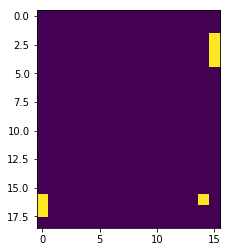

In [17]:
show(env, agent, params, 500, width=19, height=16, greedy=True)

In [18]:
# Save rewards/model
# pd.DataFrame(rewards).to_csv('models/rewards_40K_50K.csv', header=None)
saver = tf.train.Saver()
saver.save(session, 'models/Pong ActorCriticAgent', global_step=9000)

'models/Pong ActorCriticAgent-9000'